# Part 3a - Building a Flair Detector

## Get the data ready

In [0]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
data = pd.read_csv('preprocessed_data.csv')
# data = data[:500]
data = data[['flair', 'title_clean']]
data = data[pd.notnull(data['title_clean'])]
data['flair_id'] = data['flair'].factorize()[0]

# Create a feature space using tf-idf vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=20, ngram_range=(1, 2))
features = tfidf.fit_transform(data.title_clean).toarray()
labels = data.flair_id

## Some standard models

In [0]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore') 

In [0]:
# The models that we'll test
models = {'RandomForestClassifier': RandomForestClassifier(), 
          'LinearSVC': LinearSVC(), 
          'MultinomialNB': MultinomialNB(), 
          'LogisticRegression': LogisticRegression(), 
          'SGDClassifier': SGDClassifier()}

# The metrics that we'll use
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average='macro'),
           'recall': make_scorer(recall_score, average='macro'),
           'f1_macro': make_scorer(f1_score, average='macro')}

In [0]:
results = []
for name, model in models.items():

  # Cross validate with k = 5
  crossval = cross_validate(model, features, labels, scoring=scoring, cv=5)

  # Get the metrics
  accuracy = np.average(crossval['test_accuracy'])
  f1 = np.average(crossval['test_f1_macro'])
  precision = np.average(crossval['test_precision'])
  recall = np.average(crossval['test_recall'])
  results.append([name, accuracy, f1, precision, recall])

In [6]:
results = pd.DataFrame(results, columns = ['model', 'accuracy', 'f1 score', 'precision', 'recall'])
results

,model,accuracy,f1 score,precision,recall
0,RandomForestClassifier,0.505068,0.521039,0.531980,0.522742
1,LinearSVC,0.520967,0.531155,0.541206,0.532214
2,MultinomialNB,0.513514,0.521111,0.564902,0.507646
3,LogisticRegression,0.528817,0.547329,0.577673,0.534728
4,SGDClassifier,0.522557,0.523285,0.537911,0.542012


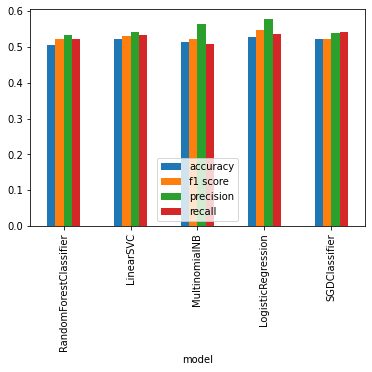

In [7]:
results.plot('model', ['accuracy', 'f1 score', 'precision' , 'recall'], kind = 'bar')

## XGBoost

In [0]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, Y_train, Y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.2)
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 14} 

In [0]:
model = xgb.train(param, D_train, 20)

In [12]:
preds = model.predict(D_test)
preds = np.asarray([np.argmax(line) for line in preds])

print("Accuracy = {}".format(accuracy_score(Y_test, preds)))
print("F1 score = {}".format(f1_score(Y_test, preds, average='macro')))
print("Precision = {}".format(precision_score(Y_test, preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, preds, average='macro')))

Accuracy = 0.48724743292480954
F1 score = 0.5362075417010216
Precision = 0.5988725807925748
Recall = 0.5099972798011994
